In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras import Model
from keras.preprocessing import image as kimage
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
import pandas as pd
import numpy as np
import spacy
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# función para visualizar gráficamente la evolución del entrenamiento
def plot_history(history, validation=False, path=None):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('binary cross entropy')
    plt.plot(history.epoch, np.array(history.history['loss']), label='Train Loss')
    if validation:
        plt.plot(history.epoch, np.array(history.history['val_loss']), label='Validation Loss')
    plt.legend()
    limite_superior = (max(history.history['loss'])-min(history.history['loss']))/2
    plt.ylim([0, limite_superior])
    
    if path:
        plt.savefig(os.path.join(path,'history.png'))

In [4]:
df_train = pd.read_pickle("C:/Users/rubio/Jupyter Notebook/AdecuacionImagenTexto/Image_Text_Matching_Model/Image_Text_Adequacy_BERT/df_train_combined.pkl")
df_test = pd.read_pickle("C:/Users/rubio/Jupyter Notebook/AdecuacionImagenTexto/Image_Text_Matching_Model/Image_Text_Adequacy_BERT/df_test_combined.pkl")

In [5]:
xtrain, xvalid, ytrain, yvalid = train_test_split(np.array(df_train['combined_input'].values.tolist()), 
                                                  df_train['label'],  
                                                  random_state=42, 
                                                  test_size=0.2)
validation_data = (xvalid,yvalid)

xtest, ytest = df_test['combined_input'],df_test['label']
xtest = np.array(xtest.tolist())
ytest = np.array(ytest.tolist())

# SEQUENTIAL MODEL

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras import Input
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

n_input = xtrain.shape[1]

i = 0
model_name = 'sequential_v' + str(i)
dir = os.path.join('./sequential_models/',model_name)

while os.path.exists(dir):
    i+=1
    model_name = 'sequential_v' + str(i)
    dir = os.path.join('./sequential_models/',model_name)

os.mkdir(dir)
    
model_extension = model_name + '.keras'
checkpoint_path = os.path.join(dir, model_extension)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,
                                                 save_best_only=True,
                                                 mode='auto')

# create model
model = Sequential()
model.add(Dense(1024, input_dim=n_input,activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
lr = 1e-3 # prueba otros valores
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2884608   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 3,573,761
Trainable params: 3,573,761
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Training the model

n_epochs = 50
b_size = 128

history = model.fit(xtrain, ytrain, verbose=1, epochs=n_epochs, batch_size=b_size, validation_data=validation_data,callbacks=[cp_callback])

Epoch 1/50
188/188 [==============================] - 3s 16ms/step - loss: 0.5008 - accuracy: 0.7966 - val_loss: 0.5005 - val_accuracy: 0.8017

Epoch 00001: val_loss improved from inf to 0.50052, saving model to ./sequential_models/sequential_v2\sequential_v2.keras
Epoch 2/50
188/188 [==============================] - 3s 15ms/step - loss: 0.4405 - accuracy: 0.8067 - val_loss: 0.4155 - val_accuracy: 0.8193

Epoch 00002: val_loss improved from 0.50052 to 0.41546, saving model to ./sequential_models/sequential_v2\sequential_v2.keras
Epoch 3/50
188/188 [==============================] - 3s 15ms/step - loss: 0.3514 - accuracy: 0.8464 - val_loss: 0.3328 - val_accuracy: 0.8543

Epoch 00003: val_loss improved from 0.41546 to 0.33278, saving model to ./sequential_models/sequential_v2\sequential_v2.keras
Epoch 4/50
188/188 [==============================] - 3s 16ms/step - loss: 0.2406 - accuracy: 0.9028 - val_loss: 0.2088 - val_accuracy: 0.9163

Epoch 00004: val_loss improved from 0.33278 to 0.2

188/188 [==============================] - 3s 16ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.0162 - val_accuracy: 0.9948

Epoch 00037: val_loss did not improve from 0.01018
Epoch 38/50
188/188 [==============================] - 3s 16ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.0649 - val_accuracy: 0.9817

Epoch 00038: val_loss did not improve from 0.01018
Epoch 39/50
188/188 [==============================] - 3s 16ms/step - loss: 0.0161 - accuracy: 0.9945 - val_loss: 0.0388 - val_accuracy: 0.9877

Epoch 00039: val_loss did not improve from 0.01018
Epoch 40/50
188/188 [==============================] - 3s 16ms/step - loss: 0.0191 - accuracy: 0.9939 - val_loss: 0.0271 - val_accuracy: 0.9912

Epoch 00040: val_loss did not improve from 0.01018
Epoch 41/50
188/188 [==============================] - 3s 16ms/step - loss: 0.0142 - accuracy: 0.9951 - val_loss: 0.0311 - val_accuracy: 0.9887

Epoch 00041: val_loss did not improve from 0.01018
Epoch 42/50
188/188 [===========

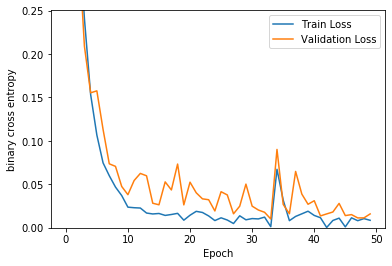

In [9]:
plot_history(history,validation=True, path=dir)

In [10]:
history_dir = os.path.join(dir,'history.npy')
np.save(history_dir, history.history)
history=np.load(history_dir,allow_pickle='TRUE').item()

In [20]:
# model_path = checkpoint_path
model_path = "C:/Users/rubio/Jupyter Notebook/AdecuacionImagenTexto/Image_Text_Matching_Model/Image_Text_Adequacy_BERT/sequential implementation/sequential_models/sequential_v2/sequential_v2.keras"
model = tf.keras.models.load_model(model_path)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              2884608   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 3,573,761
Trainable params: 3,573,761
Non-trainable params: 0
_________________________________________________________________


In [13]:
results = model.evaluate(xtest,ytest,32)

157/157 [==============================] - 1s 3ms/step - loss: 1.9971 - accuracy: 0.7982


In [14]:
def individual_prediction(id, df_test, model):
    img_path = "E:/TFM/Flickr8k/Images/" + df_test['image_id'][id] + ".jpg"
    image = plt.imread(img_path)
    plt.imshow(image)
    plt.show()
    print("Image description: ", df_test['desc'][id], "\nImage id: ",df_test['image_id'][id])
    c_i = np.asarray([df_test['combined_input'][id]])
    print("Prediction: ", model.predict_classes(c_i)[0][0])

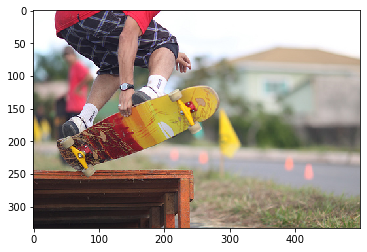

Image description:   collies are barking as they play on the edge of the ocean 
Image id:  3584930205_a3f58a4b7c
Prediction:  0


In [15]:
individual_prediction(4000, df_test, model)

In [16]:
combined_negative = df_test[df_test['label']==1]['combined_input']
out = model.predict_classes(np.array(combined_negative.values.tolist()))
unique, counts = np.unique(out, return_counts=True)
dict(zip(unique, counts))

{0: 610, 1: 390}